# Grade: /100 pts
# Assignment 8: Customer Segmentation with Clustering

In this assignment, you will be solving a traditional problem in quantitative marketing: customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. In this ocassion you are going to analyze customers of an automobile company.

Assume you are the owner of a consulting company that is in charge of this project. In this assignment you are going to conduct 2 different strategies for segmentating the potential customers.

The information is provided in the document `DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# pip install yellowbrick
#from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

%matplotlib inline

## Question 1 Loading the data and Preprocessing (10 pts)


1. Import the data. Report the data shape. How many null values in each column?

In [2]:
# read csv file
data_set = pd.read_csv(filepath_or_buffer='DATA.csv')

# Shape of dataset
print('>    Dataset shape: {}'.format(data_set.shape))

# Number of null in each column
print('>    Number of NULL in each column:')
print(data_set.isnull().sum(axis=0))

>    Dataset shape: (8068, 10)
>    Number of NULL in each column:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


2. For the column `Work_Experience` and `Family_Size`, use median value to replace the null values. For each of other columns with null entries, use the most frequent level in a column to replace the null values in this column.

In [3]:
# Fill null with median
data_set['Work_Experience'] = data_set['Work_Experience'].fillna(value=data_set['Work_Experience'].median())
data_set['Family_Size'] = data_set['Family_Size'].fillna(value=data_set['Family_Size'].median())

# Fill with most frequent value
for column_i in data_set.columns:
    data_set[column_i] = data_set[column_i].fillna(value=data_set[column_i].mode().values[0])


3. Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 10 rows.

In [4]:
# Encode all categorical labels
data_set = pd.get_dummies(data=data_set, drop_first=True)

# first 10 row of dataset
data_set.head(10)

,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Marketing,Profession_Other,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.0,4.0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,462643,38,1.0,3.0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,466315,67,1.0,1.0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,461735,67,0.0,2.0,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,462669,40,1.0,6.0,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
5,461319,56,0.0,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,460156,32,1.0,3.0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
7,464347,33,1.0,3.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,465015,61,0.0,3.0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
9,465176,55,1.0,4.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


4. Then standardize your data (except the `ID` column) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [5]:
# standardize
data_set_stan = StandardScaler().fit_transform(data_set.drop(columns=['ID']))

# remove ID
columns_name = data_set.columns.tolist()
columns_name.remove('ID')

# Convert to dataframe
data_set_stan = pd.DataFrame(data=data_set_stan, columns=columns_name)

data_set_stan.head(5)

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Healthcare,Profession_Marketing,Profession_Other,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-1.284623,-0.451136,0.762698,0.909164,-1.206653,-1.29219,-0.305328,-0.307988,-0.365110,2.248790,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
1,-0.327151,-0.451136,0.095802,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,-1.236590,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
2,1.408268,-0.451136,-1.237990,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
3,1.408268,-0.757410,-0.571094,0.909164,0.828738,0.77388,-0.305328,-0.307988,-0.365110,-0.444684,-0.193782,2.016888,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
4,-0.207467,-0.451136,2.096491,-1.099912,0.828738,0.77388,-0.305328,-0.307988,2.738901,-0.444684,-0.193782,-0.495813,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657


## Question 2: First Strategy (45 pts)

1. We use K-means method to conduct the clustering analysis by setting the seed to 9. Use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function to find the optimal number of clusters, where sets `k=(2,10)` and `metric` as default. **Written answer: Can you find the optimal number of clusters using the elbow method?**

/home/farhad-bat/.local/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/farhad-bat/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


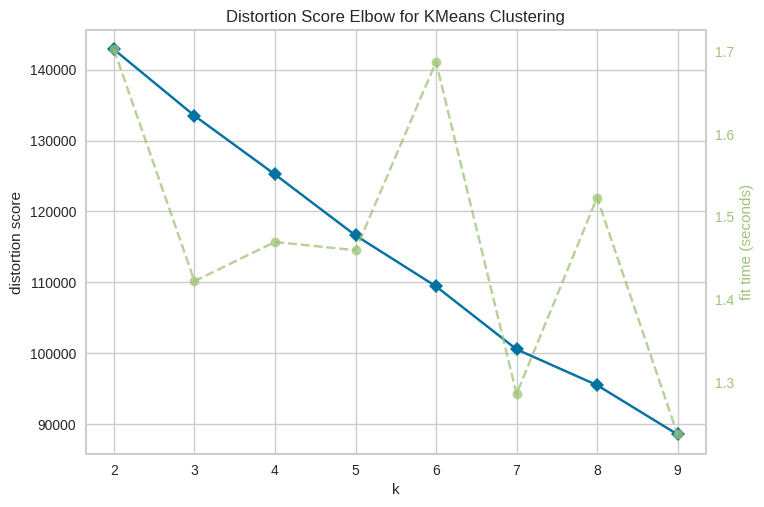

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# k-mean object
kmean_obj = KMeans(n_clusters=2, random_state=9)

# K elbow object
kelbow_visualizer = KElbowVisualizer(estimator=kmean_obj, metric='distortion', k=(2, 10), locate_elbow=True, timings=True)

kelbow_visualizer.fit(X=data_set_stan)
kelbow_visualizer.show()

**Written answer (2 pts): No, in this case and with this parameter, elbow method fail to give us the opimal number of clusters.**

2. Try between 2 and 6 clusters, using a seed of 9, and draw the silouhette plot for the K-means analysis. Report the silhouette scores. Do NOT use the built-in function `SilhouetteVisualizer()`.

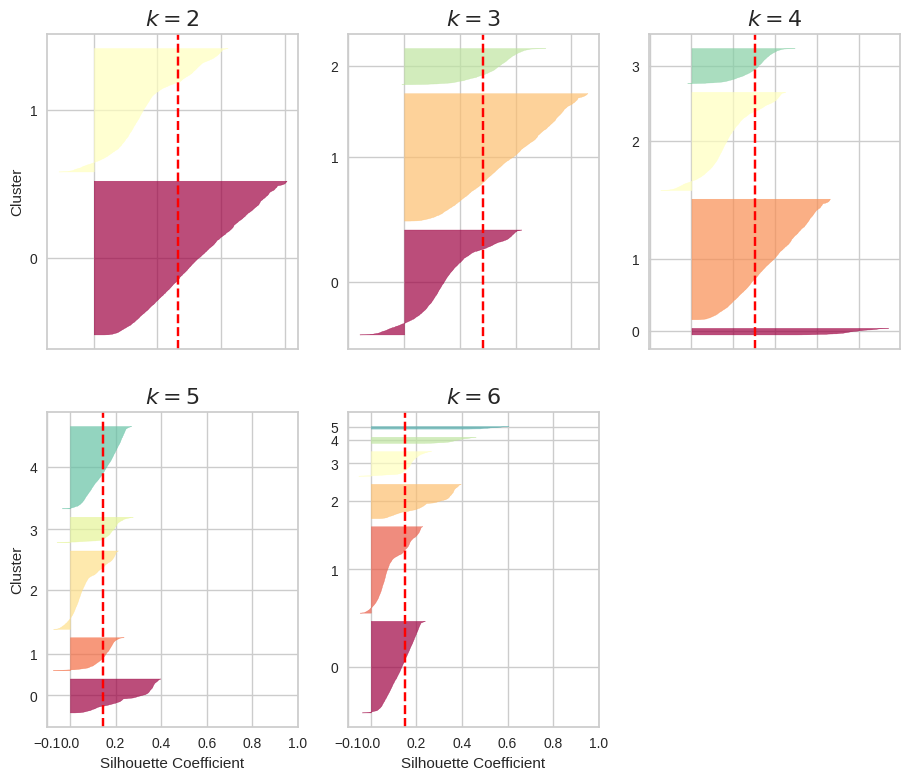

Text(0.5, 1.0, 'Silhouette score for different number of clusters.')

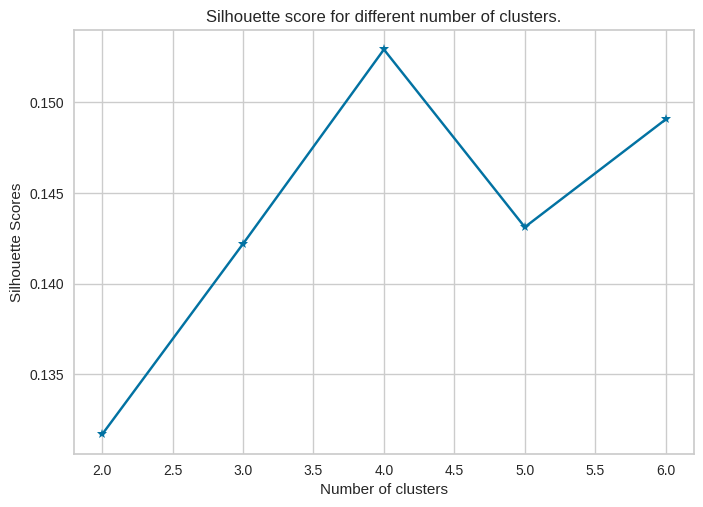

In [7]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

#  figure size
plt.figure(figsize=(11, 9))

# copy of input data
input_data_this_section = data_set_stan.copy()
# different values for number of clusters
k_clusters = [i for i in range(2, 7)]
# number of row and column in the plot
plot_row = 2
plot_col = 3

# train a KMean for each number of cluster 
kmeans_per_k = [KMeans(n_clusters=k, random_state=9).fit(input_data_this_section) for k in k_clusters]
# silhoutte score for each clustring model 
silhouette_scores = [silhouette_score(input_data_this_section, model.labels_) for model in kmeans_per_k]

# for each different number of clusters plot silhoutter score plot
for idx, k in enumerate(k_clusters):
    
    # select subplot
    plt.subplot(plot_row, plot_col, idx + 1)
    
    y_pred = kmeans_per_k[idx].labels_
    silhouette_coefficients = silhouette_samples(input_data_this_section, y_pred)

    padding = len(input_data_this_section) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    # y axis label
    if idx % plot_col == 0:
        plt.ylabel("Cluster")
    
    # x axis label
    if idx // plot_col == plot_row - 1:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
        
    # average line and title
    plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

plt.plot(k_clusters, silhouette_scores, '*-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette score for different number of clusters.')

**What is the optimal number of clusters using the silhouette method? **

**ANSWER HERE (2pts): 4 cluster gives the highest Silhouette Scores. Therefore, 4 cluster is better according to this metric.** 

3. Use the first and second principle components of the data as the x and y axis, draw the scatter plot where points are differentiated by clusters. Hints: you need to first perform dimension reduction with PCA using 2 components.

<Axes: xlabel='pc1', ylabel='pc2'>

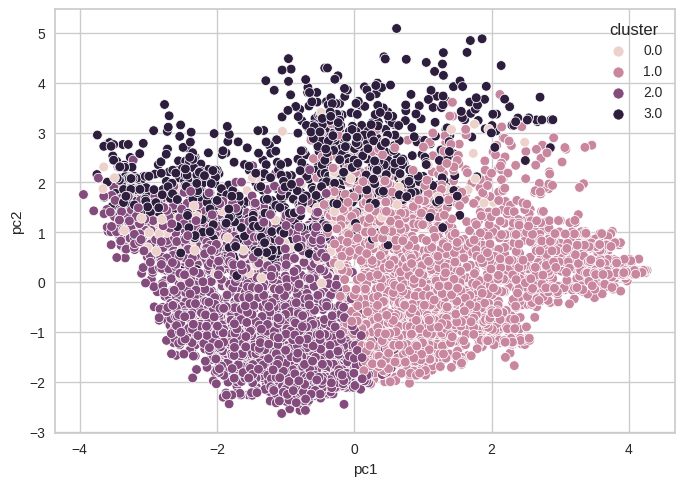

In [8]:
# PCA object
pca_obj = PCA(n_components=2, svd_solver='full')
data_set_stan_projected_pca = pca_obj.fit_transform(X=data_set_stan)

# best selected clustring in 2-2
kmean_obj = KMeans(n_clusters=4, random_state=9).fit(data_set_stan)

# create a data frame by principal component 1 and 2 and cluster labels
data_set_stan_projected_pca = pd.DataFrame(data=np.concatenate([data_set_stan_projected_pca, kmean_obj.labels_.reshape((-1, 1))], axis=1), columns=['pc1', 'pc2', 'cluster'])

# plot
sns.scatterplot(data=data_set_stan_projected_pca, x='pc1', y='pc2', hue='cluster')



4. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Question 1, create a table (using `pandas.DataFrame.groupby`) of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [9]:
# copy of orginal data with cluster name
data_set_copy  = data_set[['Age', 'Work_Experience', 'Family_Size']].copy()
data_set_copy['cluster_label'] = kmean_obj.labels_

# do grouping by cluster label
grouped_data_frame = data_set_copy.groupby('cluster_label').mean()

# shpw result
grouped_data_frame.head(4)

,Age,Work_Experience,Family_Size
cluster_label,,,
0,38.630542,2.512315,3.221675
1,54.010712,2.095072,2.653455
2,32.471245,3.036477,2.853105
3,38.936581,2.186581,3.493566


**ANSWER HERE (2pts): Cluster 0 and 3 have similar average values, however for the two other cluster are highly different. Work experience. The values follow the same pattern that the PCA image shows: cluster 1 and 3 are distinct in a good degree and cluster 0 and 3 are harder to distinquish from others.** 

## Question 3: Second Strategy (45 pts) 

1. First performing dimension reduction with PCA using 4 components. Look for the best number of clusters (between 3 to 6) using `Agglomerative clustering` with `affinity = 'cosine'` and `linkage = 'average'` and Silhuoette analysis.

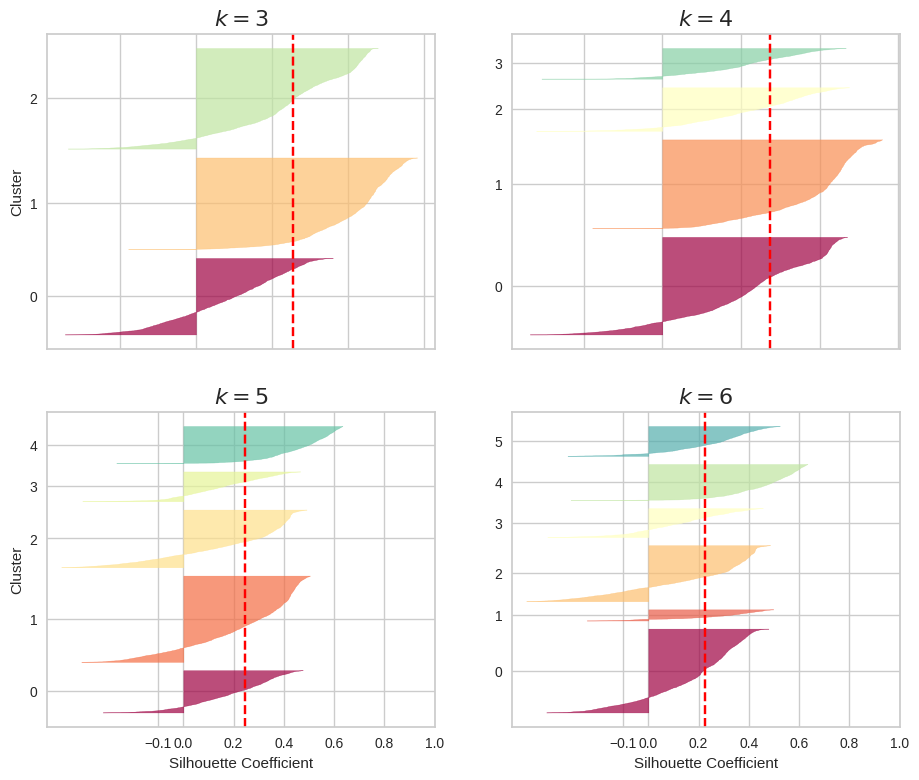

Text(0.5, 1.0, 'Silhouette score for different number of clusters.')

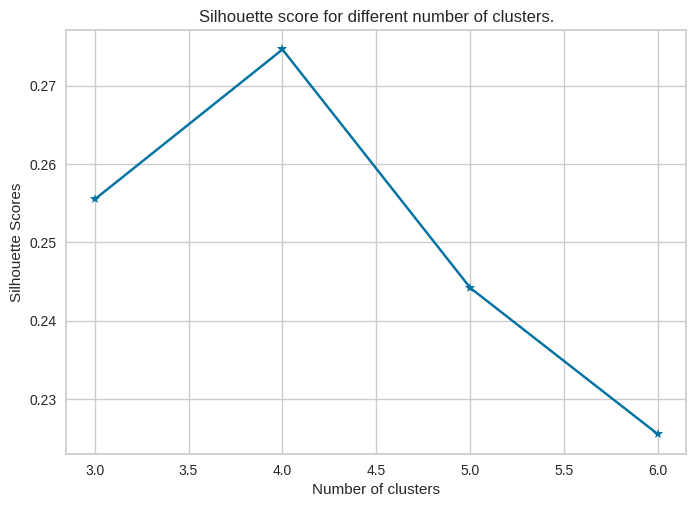

In [10]:
# PCA object
pca_obj = PCA(n_components=4, svd_solver='full')
data_set_stan_projected_pca = pca_obj.fit_transform(X=data_set_stan)

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

#  figure size
plt.figure(figsize=(11, 9))

# copy of input data
input_data_this_section = data_set_stan_projected_pca.copy()
# different values for number of clusters
k_clusters = [i for i in range(3, 7)]
# number of row and column in the plot
plot_row = 2
plot_col = 2

# train a KMean for each number of cluster 
agg_cluster_per_k = [AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average').fit(input_data_this_section) for k in k_clusters]
# silhoutte score for each clustring model 
silhouette_scores = [silhouette_score(input_data_this_section, model.labels_) for model in agg_cluster_per_k]

# for each different number of clusters plot silhoutter score plot
for idx, k in enumerate(k_clusters):
    
    # select subplot
    plt.subplot(plot_row, plot_col, idx + 1)
    
    y_pred = agg_cluster_per_k[idx].labels_
    silhouette_coefficients = silhouette_samples(input_data_this_section, y_pred)

    padding = len(input_data_this_section) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    # y axis label
    if idx % plot_col == 0:
        plt.ylabel("Cluster")
    
    # x axis label
    if idx // plot_col == plot_row - 1:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
        
    # average line and title
    plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

plt.plot(k_clusters, silhouette_scores, '*-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette score for different number of clusters.')

**Written Answer:** How many clusters is select based on the previous results?

**ANSWER HERE (2pts): According to the result, 4 number of cluster is the best choice for clustring with AgglomerativeClustering with asked settings.** 

2. Graph the scatter plot of the PCA-transformed data differentiated by cluster. Use the first and second principal components of the data as the x and y axis.


<Axes: xlabel='pc1', ylabel='pc2'>

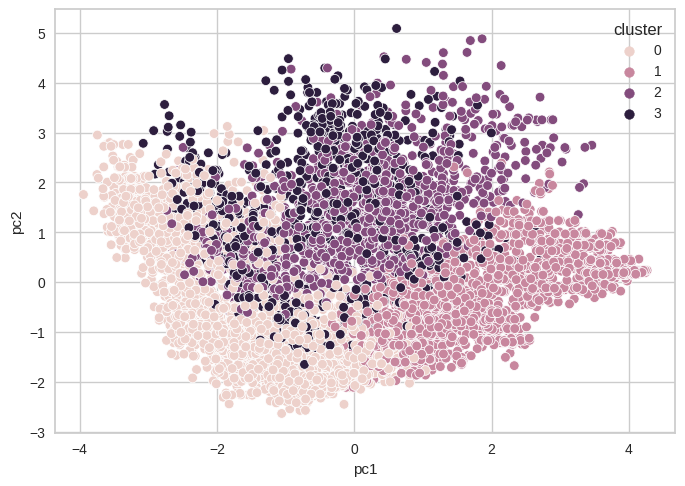

In [11]:
# best selected cluster
best_aggl_obs = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average').fit(data_set_stan_projected_pca)

plot_data_frame = pd.DataFrame()
plot_data_frame['pc1'] = data_set_stan_projected_pca[:, 0]
plot_data_frame['pc2'] = data_set_stan_projected_pca[:, 1]  
plot_data_frame['cluster'] = best_aggl_obs.labels_

# plot
sns.scatterplot(data=plot_data_frame, x='pc1', y='pc2', hue='cluster')

3. Make the boxplot `Age` vs `Family_Size` based on the dataFrame before standardization, and use `hue = "Your_Cluster_Label"` in the plot function to show the differences among clusters.

<Axes: xlabel='Family_Size', ylabel='Age'>

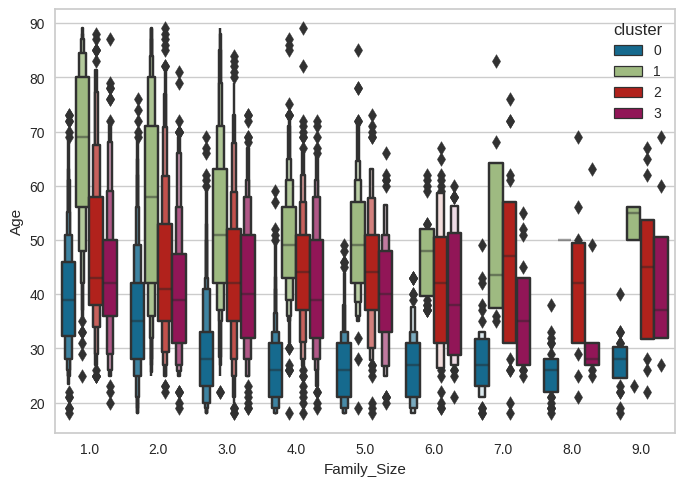

In [12]:
# create dataframe
dataset_box_plot = data_set.copy()
dataset_box_plot['cluster'] = plot_data_frame['cluster'].values

# create boxplot
sns.boxenplot(data=dataset_box_plot, x='Family_Size', y='Age', hue='cluster')

4. Using the number of clusters you have decided in Question 2 and `pandas.DataFrame.groupby`, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [13]:
# copy of orginal data with cluster name
data_set_copy  = data_set[['Age', 'Work_Experience', 'Family_Size']].copy()
data_set_copy['cluster_label'] = best_aggl_obs.labels_

# do grouping by cluster label
grouped_data_frame = data_set_copy.groupby('cluster_label').mean()

# shpw result
grouped_data_frame.head(4)

,Age,Work_Experience,Family_Size
cluster_label,,,
0,32.007944,3.035750,3.003972
1,56.051962,2.034157,2.609738
2,44.755572,2.109212,3.011887
3,41.621707,2.469968,2.880927


**ANSWER HERE (2pts): Cluster (0) members can represent young people with a lot of focus on their career and families. Cluster (1) can represent people who are old and have not shown a lot of interest toward their career and family. Cluster (2) can represent people who valued family more than their job. Finally, cluster (3) can show people who created a good balance between their job and their families.** 

